In [1]:
import numpy as np
import cv2
import os
import math
import numpy.linalg as linalg
import sys
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.signal
from keras.models import *
import sqlite3
%matplotlib inline 
import glob
import pickle


c:\anaconda\envs\ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def CameraMatrix(fx, fy, cx, cy):
    K = np.array([ [fx, 0, cx], [0, fy, cy ], [0,0,1] ])
    return K

def TransformCameraOnZPlane(img_col, img_ir, K_cam1, K_cam2, z, cam_shift=[0,0,0], coords_in=None, debug=False):
    
    if coords_in is None:
        # Generate a vector of points on a plane
        P = np.zeros( ( img_col.shape[0]*img_col.shape[1],3 ), dtype=np.float32 )
        i = 0
        for x in range(img_col.shape[1]):
            for y in range(img_col.shape[0]):
                P[i,0] = x
                P[i,1] = y
                P[i,2] = 1
                i+=1
    else:
        P = coords_in

    if debug:
        print('P shape:')
        print(P.shape)
    K_cam1_inv = linalg.inv(K_cam1)
    P_out = np.matmul(  K_cam1_inv, np.transpose(P) )
    P_out = np.transpose(P_out)
    if debug:
        print(P_out.shape)
    for i in range(0, P_out.shape[0]):
        s = z/P_out[i,2]
        P_out[i,0] = P_out[i,0]*s
        P_out[i,1] = P_out[i,1]*s
        P_out[i,2] = P_out[i,2]*s
        
        
    I = np.eye(3, dtype=np.float32)
    C = np.array( [ 40, 0,0 ], dtype=np.float32 ) # do we even use it?
    IC = np.zeros((3,4), dtype=np.float32)
    IC[0:3, 0:3] = I
    IC[0, 3] = cam_shift[0]     
    IC[1, 3] = cam_shift[1]     
    IC[2, 3] = cam_shift[2]     
    
    KIC = np.matmul(K_cam2, IC)
    
    # Generate homogeneous coordinates
    o = np.ones((P_out.shape[0],1), dtype=np.float32)
    P_out_4D = np.hstack((P_out, o))
    if debug:
        print(P_out_4D)
        print(P_out_4D.shape)


    if 0:
        P_out_4D = np.array(  [ 0,0,z,1 ], dtype=np.float32)
        P_out_4D = np.reshape( P_out_4D, (1,4) )
        print(P_out_4D.shape)

    # Transform
    out = np.matmul( KIC, np.transpose(P_out_4D))
    if debug:
        print('out shape:')
        print(out.shape)
    out = np.transpose(out)
    print(out.shape)
    out[:,0] = np.divide(out[:,0], out[:,2])
    out[:,1] = np.divide(out[:,1], out[:,2])
    out[:,2] = np.divide(out[:,2], out[:,2])

    # Actual center of IR image 243.892, 208.922
    if debug:
        print('Final=')
        print(out)
    
#    img_ir = np.array(Image.open(image_ir), dtype=np.float32)

    if debug:
        print(img_ir.shape)
        print(P.shape)
        print(out.shape)




    img = np.zeros( (img_ir.shape[0], img_ir.shape[1], 3) )
    for i in range(0, out.shape[0]):
        p_out = out[i,:].astype(np.int64)
        p_in = P[i,:].astype(np.int64)
        try :
            img[ p_out[1], p_out[0],: ] = img_col[ p_in[1], p_in[0], : ]
        except:
            continue
            #print('Out of bounds')


    if debug:
        plt.imshow(img_ir, cmap='gray')
        plt.show()

        plt.imshow(img_col.astype(np.uint8))
        plt.show()
        plt.imshow(img.astype(np.uint8))
        plt.show()   
        
    return img


def drawConnectedComponents(img):
    out = cv2.connectedComponents(img.astype(np.uint8))
    plt.imshow(out[1])
    plt.show()

    for i,val in enumerate(np.unique(out[1])):
        perc = np.sum(out[1]==val)/np.prod(out[1].shape)
        plt.imshow( np.multiply(out[1], out[1]==val) )
        plt.title('ID: {}, perc: {}%'.format(i,100*perc))
        plt.show()



def TransformCoordinates(P, K_cam1, K_cam2, z, cam_shift=[0,0,0], debug=False):
    
    P = np.array(P, dtype=np.float32)
    if(len(P.shape)==2):
        o = np.ones( (P.shape[0], 1), dtype=np.float32 )
        P = np.hstack((P, o))
    
        print(P)
    
    K_cam1_inv = linalg.inv(K_cam1)
    P_out = np.matmul(  K_cam1_inv, np.transpose(P) )
    P_out = np.transpose(P_out)
    for i in range(0, P_out.shape[0]):
        s = z/P_out[i,2]
        P_out[i,0] = P_out[i,0]*s
        P_out[i,1] = P_out[i,1]*s
        P_out[i,2] = P_out[i,2]*s


    I = np.eye(3, dtype=np.float32)
    C = np.array( [ 40, 0,0 ], dtype=np.float32 )
    IC = np.zeros((3,4), dtype=np.float32)
    IC[0:3, 0:3] = I
    IC[0, 3] = cam_shift[0]     
    IC[1, 3] = cam_shift[1]     
    IC[2, 3] = cam_shift[2]     

    KIC = np.matmul(K_cam2, IC)

    o = np.ones((P_out.shape[0],1), dtype=np.float32)
    P_out_4D = np.hstack((P_out, o))


    out = np.matmul( KIC, np.transpose(P_out_4D))
    out = np.transpose(out)
    for i in range(0, out.shape[0]):
        out[i, 0] = out[i,0]/out[i,2]
        out[i, 1] = out[i,1]/out[i,2]
        out[i, 2] = out[i,2]/out[i,2]


    return out[:, 0:2]


# Using: https://threeconstants.wordpress.com/2014/11/09/kinect-v2-depth-camera-calibration/
#Focal Length (x,y) :   391.096, 463.098
#Principle Point (x,y): 243.892, 208.922
K_IR = np.array([ [391.096, 0, 243.892], [0, 463.098, 208.922 ], [0,0,1] ])
print('K IR:')
print(K_IR)


# Color properties from: https://github.com/OpenKinect/libfreenect2/issues/41
#fx 1060.707250708333, cx 956.354471815484
#fy 1058.608326305465, cy 518.9784429882449
K_Color = np.array([[ 1060.707250708333, 0, 956.354471815484 ], [0,1058.608326305465, 518.9784429882449 ], [0,0,1] ])


K_IR = CameraMatrix(351.096, 363.098,243.892,208.922)


P = [ [0,0], [1920, 1080], [600,600] ]
TransformCoordinates(P, K_Color, K_IR, 2500, cam_shift=[26,-35,0], debug=False)




K IR:
[[391.096   0.    243.892]
 [  0.    463.098 208.922]
 [  0.      0.      1.   ]]
[[0.00e+00 0.00e+00 1.00e+00]
 [1.92e+03 1.08e+03 1.00e+00]
 [6.00e+02 6.00e+02 1.00e+00]]


array([[-69.01164486,  25.8313046 ],
       [566.51179438, 396.2665546 ],
       [129.5894299 , 231.62866571]])

In [3]:
# img is the depth image
def get_normals(img):
    normals = np.zeros(( img.shape[0], img.shape[1], 3 ))

    r = 5
    for x in range(r, img.shape[1]-r):
        for y in range(r,img.shape[0]-r):
            a = np.array([ x-r, y, img[y,x-r] ])
            b = np.array([ x, y-r, img[y-r,x] ])
            c = np.array([ x, y, img[y,x] ])
            z = np.cross( a-c, b-c )
            z = np.divide(z, np.linalg.norm(z))
            normals[y,x,:] = z

    
    for i in range(0,3):        
        plt.figure(figsize=(20,10))
        plt.imshow(normals[:,:,i])
        plt.title('Normals channel : {}'.format(i))
        plt.show()
    return normals


def filter_masks( instance_mask_img, numpix_th=100 ):
    l = cv2.cvtColor(instance_mask_img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    j = 1
    output_mask = np.zeros(( instance_mask_img.shape[0], instance_mask_img.shape[1] ))
    for val in np.unique(l):
        numpix = np.sum(l==val)
        if numpix > numpix_th and val > 0:
            output_mask = np.multiply(output_mask, output_mask>0) + j*np.multiply(l==val, output_mask==0)
            j +=1
    return output_mask

def load_and_transform_for_prefix(prefix):
    conn = sqlite3.connect('E:/Captures/2017_03_07_17_16_25/Files.sqlite')
    c = conn.execute('SELECT * FROM generalFiles WHERE filename LIKE \'%{}%\''.format(prefix))
    finfo = c.fetchone()[0]
    conn.close()

    finfo = finfo.replace('\\', '/')
    fpath_depth = os.path.join('E:/Captures/2017_03_07_17_16_25','Depth', finfo + '.png')
    fpath_color = os.path.join('E:/Captures/2017_03_07_17_16_25','Color', finfo + '.jpg')
    fpath_ir = os.path.join('E:/Captures/2017_03_07_17_16_25','Infrared', finfo + '.jpg')

    print('Loading images...')
    img_ir = np.array(Image.open(fpath_ir), dtype=np.float32)
    img_col = np.array(Image.open(fpath_color), dtype=np.float32)
    imgd = np.array(Image.open(fpath_depth), dtype=np.float32)

    print('Transforming...')
    img = TransformCameraOnZPlane(img_col, img_ir, K_Color, K_IR, 2500.0, cam_shift=[26,-35,0])
    img_col_trans = img


    ret = dict()
    ret['color_orig'] = img_col
    ret['ir'] = img_ir
    ret['color_trans'] = img
    ret['depth'] = imgd

    if 0:
        plt.figure(figsize=(20,10))
        plt.imshow(img_col.astype(np.uint8))
        plt.title('Original color image')
        plt.show()

        plt.figure(figsize=(20,10))
        plt.imshow(img_ir)
        plt.title('IR Image')
        plt.show()

        plt.figure(figsize=(20,10))
        plt.imshow(img.astype(np.uint8))
        plt.title('Color image transformed')
        plt.show()

        plt.figure(figsize=(20,10))
        plt.imshow(imgd, cmap='gray')
        plt.title('Depth image')
        plt.show()
    return ret



def normalize(x):
    """
    Normalize input to be zero mean and divide it by its global maximum value. 
    """

    x = x - np.min(x, keepdims = False)
    x = x/(np.max(x, keepdims = False) + 1e-10)
    return np.copy(x)

def remove_random_labels(intmask, keep_prob=0.7):
    out = np.copy(intmask)*0
    vals = np.unique(intmask)[1:] # skip the zero
    tokeep = np.where(np.random.uniform(0,1,(vals.shape[0]))<keep_prob)[0]
    j=1
    for val in vals[tokeep]:
        out = np.multiply(out, out>0) + j*np.multiply( intmask==val, out==0 )
        j = j+1
    return out
    
    

In [4]:
with open('floorplane.pickle', 'rb') as file:
    floorplane = pickle.load(file)

Example 22 / 23 - 2017_03_23_09_44_15_872
Loading images...
Transforming...
(2073600, 3)
(2073600, 3)


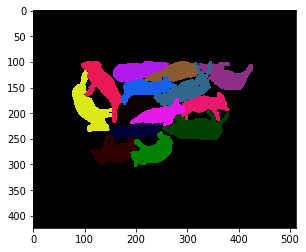

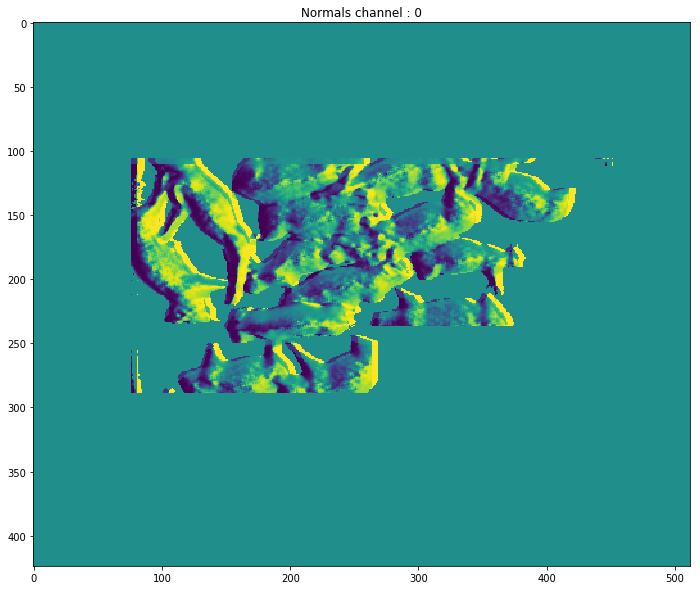

In [ ]:


ir_mask = np.array(Image.open('ir_mask.png'))>0        

plt.imshow(floorplane)
plt.show()


# GET THE MASK FILES
mask_fpaths = glob.glob('D:/Datasets/PigMasks_2017_03_07/*png')
for i,mask_fpath in enumerate(mask_fpaths):
    clear_output()
    prefix = os.path.basename(mask_fpath)[0:-9]
    print('Example {} / {} - {}'.format(i, len(mask_fpaths), prefix))
    instance_mask_img = np.array(Image.open(mask_fpath), dtype=np.float32)[:,:,0:3]

    
    data = load_and_transform_for_prefix(prefix)

    instance_mask_img_transformed = TransformCameraOnZPlane(instance_mask_img, data['ir'], K_Color, K_IR, 2500.0, cam_shift=[26,-35,0])
    plt.imshow(instance_mask_img_transformed)
    plt.show()
    
    data['instance_mask_trans'] = instance_mask_img_transformed
    data['instance_mask'] = instance_mask_img
    data['heightmap'] = floorplane-data['depth']
    data['heightmap_masked'] = np.multiply(data['heightmap'], ir_mask)
    data['heightmap_masked'] = np.multiply(data['heightmap_masked'], data['heightmap_masked']>50)
    data['heightmap_masked'] = np.multiply(data['heightmap_masked'], data['heightmap_masked']<600)
    data['normals'] = get_normals(data['heightmap_masked'])
    data['integer_mask'] = filter_masks(instance_mask_img_transformed)
    
    out_fname = prefix + '.pickle'
    with open(out_fname, 'wb') as file:
        print('Saving file...  {}'.format(out_fname))
        pickle.dump(data, file)
    


clear_output()
print('DONE!')
    